**HW6 Summary Analysis**

Point of interest is chosen using cv.goodFeaturesToTrack() based on the Shi-Tomasi method for corner detection. These points are then tracked into the second image using the Lucas-Kanade optical flow algorithm via cv2.calcOpticalFlowPyrLK(). We estimate the FOE by modeling the flow vectors. For each tracked point in image1, we derive a linear constraint based on pure camera translation, the observed displacement should point away from or towards the FOE. We then solve the over-determined system using least squares. Independently moving objects are detected by comparing the actual flow vectors to the expected ones defined by the FOE. Significant angular discrepancies flag points as outliers, which are then grouped using DBSCAN clustering.

Some weaknesses arise when there is small motions where corner detection and optical flow can yield sparse results. The FOE estimation is weak when there are significant rotations or when scene depth variation complicates the pure translation assumption. Images examples of weak performance are image pair 16 and image pair 25.

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def get_image_pairs(data_dir):
    image_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.png')])
  
    #make pairs assuming sequential ones are pairs
    pairs = []
    for i in range(0, len(image_files)-1, 2):
        pair = (os.path.join(data_dir, image_files[i]), os.path.join(data_dir, image_files[i+1]))
        pairs.append(pair)
    return pairs

In [17]:
def process_image_pair(img_path0, img_path1, pair_index, angle_threshold=0.2):
    print(f"Processing pair: {img_path0} and {img_path1}")
    
    I0 = cv2.imread(img_path0)
    I1 = cv2.imread(img_path1)
    
    if I0 is None or I1 is None:
        print("Error loading images.")
        return None, None  # Return None if loading failed

    gray0 = cv2.cvtColor(I0, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
    
    # -----------------------------------------------
    #           Optical Flow Estimation
    # -----------------------------------------------

    #https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html 
    features0 = cv2.goodFeaturesToTrack(gray0, maxCorners=1000, qualityLevel=0.01, minDistance=7)
    features1, st, err = cv2.calcOpticalFlowPyrLK(gray0, gray1, features0, None)
    
    if features1 is None:
        print("No features tracked in the second image.")
        return None, None
    
    good_features0 = features0[st.flatten() == 1]
    good_features1 = features1[st.flatten() == 1]
    
    # -----------------------------------------------
    #               FOE Estimation
    # -----------------------------------------------
    A = []
    b = []
    for pt0, pt1 in zip(good_features0.reshape(-1, 2), good_features1.reshape(-1, 2)):
        flow = pt1 - pt0
        x, y = pt1  #use the location in I1 for the constraint
        u, v = flow
        A.append([-v, u])
        b.append(-v * x + u * y)
    A = np.array(A)
    b = np.array(b)
    
    FOE, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    print("Estimated FOE:", FOE)
    
    # -----------------------------------------------
    #           Independent Motion Detection
    # -----------------------------------------------
    independent_points = []
    inlier_points = []
    
    for pt0, pt1 in zip(good_features0.reshape(-1,2), good_features1.reshape(-1,2)):
        expected_vector = pt1 - FOE
        expected_norm = np.linalg.norm(expected_vector)
        expected_dir = expected_vector / expected_norm if expected_norm != 0 else expected_vector
        
        flow_vector = pt1 - pt0
        flow_norm = np.linalg.norm(flow_vector)
        flow_dir = flow_vector / flow_norm if flow_norm != 0 else flow_vector
        
        dot_prod = np.dot(expected_dir, flow_dir)
        dot_prod = np.clip(dot_prod, -1.0, 1.0)
        angle_diff = np.arccos(dot_prod)
        
        if angle_diff > angle_threshold:
            independent_points.append(pt1)
        else:
            inlier_points.append(pt1)
    
    print(f"Total tracked points: {len(good_features1)}, Independent points: {len(independent_points)}")
    
    # -----------------------------------------------
    #           Independent Point CLustering
    # -----------------------------------------------
    if len(independent_points) > 0:
        independent_points_arr = np.array(independent_points)
        clustering = DBSCAN(eps=15, min_samples=5).fit(independent_points_arr)
        labels = clustering.labels_
    else:
        labels = np.array([])
    
    # -----------------------------------------------
    #               Output Images
    # -----------------------------------------------
    #copy of I1 for drawing motion vectors and FOE
    visualization = I1.copy()
    for pt0, pt1 in zip(good_features0.reshape(-1,2), good_features1.reshape(-1,2)):
        pt0_int = tuple(np.int32(pt0))
        pt1_int = tuple(np.int32(pt1))
        cv2.arrowedLine(visualization, pt0_int, pt1_int, color=(0,255,0), thickness=1, tipLength=0.3)
    
    if np.linalg.norm(FOE) > 0:
        FOE_point = tuple(np.int32(FOE))
        cv2.circle(visualization, FOE_point, 5, (0,0,255), -1)
        cv2.putText(visualization, "FOE", FOE_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
    else:
        cv2.putText(visualization, "No camera motion detected", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    
    #create a separate copy of I1 for independent motion clusters
    cluster_visualization = I1.copy()
    if len(independent_points) > 0:
        unique_labels = set(labels)
        for label in unique_labels:
            if label == -1:
                continue
            indices = np.where(labels == label)[0]
            cluster_pts = independent_points_arr[indices]
            color = tuple(np.random.randint(0, 255, 3).tolist())
            for pt in cluster_pts:
                pt_int = tuple(np.int32(pt))
                cv2.circle(cluster_visualization, pt_int, 4, color, -1)
            x, y, w, h = cv2.boundingRect(cluster_pts.astype(np.int32))
            cv2.rectangle(cluster_visualization, (x, y), (x+w, y+h), color, 2)
    else:
        cv2.putText(cluster_visualization, "No independent motion detected", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    
    return visualization, cluster_visualization


Processing pair: hw6data/000003_10.png and hw6data/000003_11.png
Estimated FOE: [737.2317  219.71225]
Total tracked points: 971, Independent points: 805


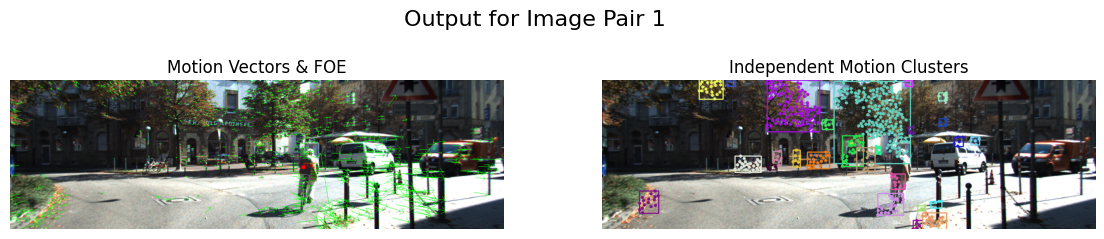

Processing pair: hw6data/000005_10.png and hw6data/000005_11.png
Estimated FOE: [617.68146 169.12453]
Total tracked points: 924, Independent points: 238


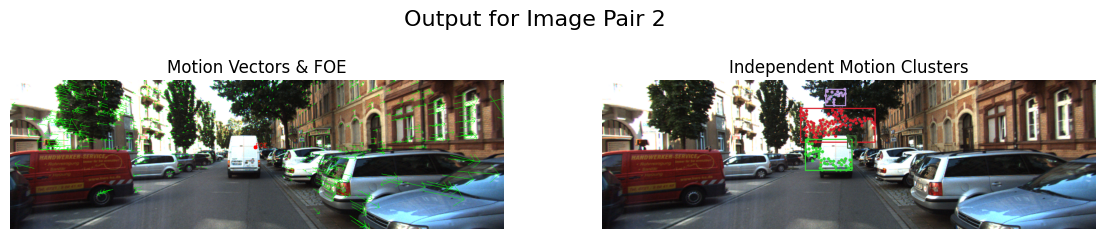

Processing pair: hw6data/000017_10.png and hw6data/000017_11.png
Estimated FOE: [519.12415 185.77826]
Total tracked points: 970, Independent points: 906


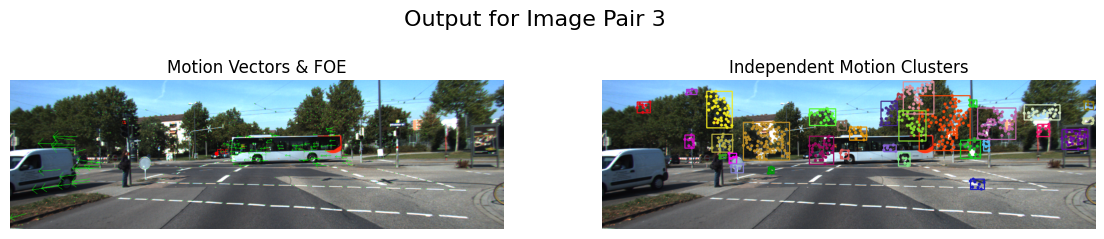

Processing pair: hw6data/000020_10.png and hw6data/000020_11.png
Estimated FOE: [348.05643 232.9287 ]
Total tracked points: 900, Independent points: 653


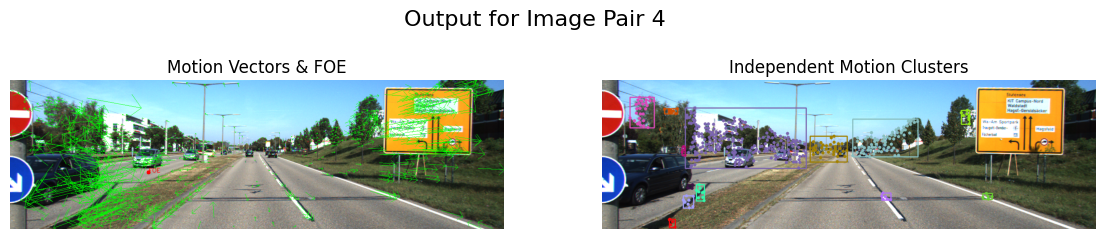

Processing pair: hw6data/000035_10.png and hw6data/000035_11.png
Estimated FOE: [596.57404 181.95122]
Total tracked points: 940, Independent points: 164


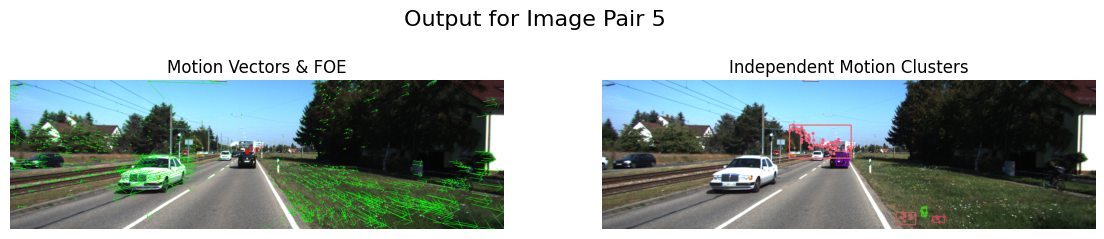

Processing pair: hw6data/000066_10.png and hw6data/000066_11.png
Estimated FOE: [937.8765  146.17366]
Total tracked points: 858, Independent points: 670


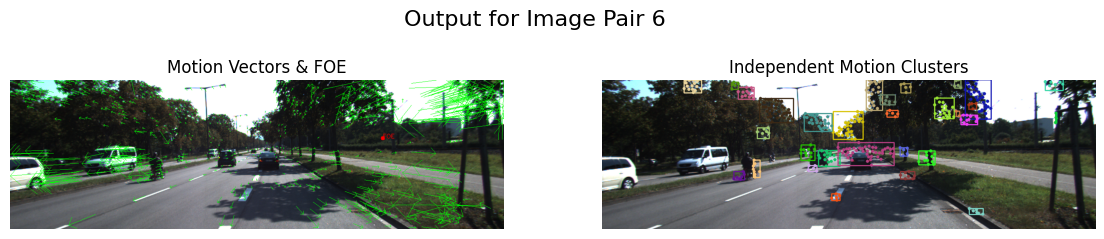

Processing pair: hw6data/000067_10.png and hw6data/000067_11.png
Estimated FOE: [902.6307  174.56688]
Total tracked points: 935, Independent points: 464


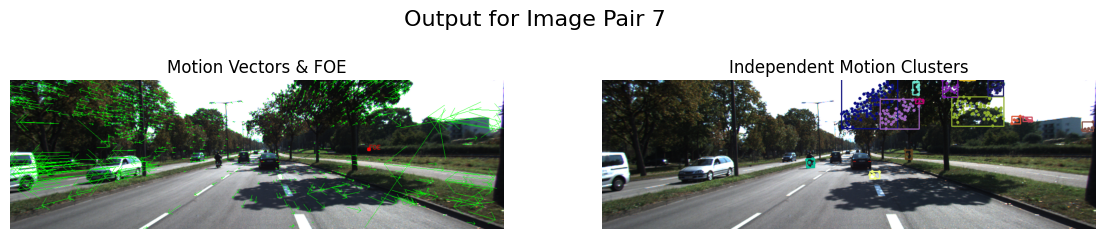

Processing pair: hw6data/000101_10.png and hw6data/000101_11.png
Estimated FOE: [494.35745 173.84041]
Total tracked points: 888, Independent points: 418


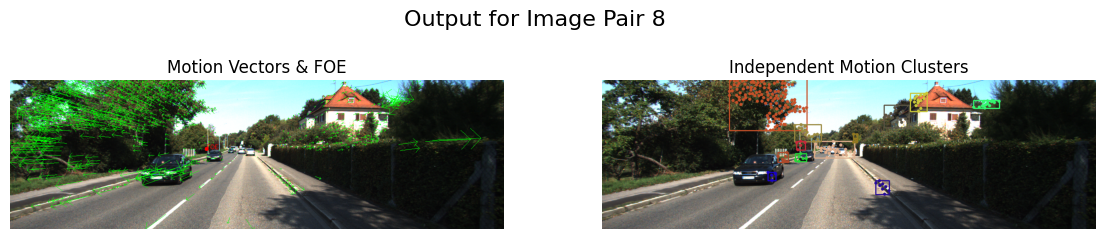

Processing pair: hw6data/000102_10.png and hw6data/000102_11.png
Estimated FOE: [668.4919  209.21385]
Total tracked points: 912, Independent points: 445


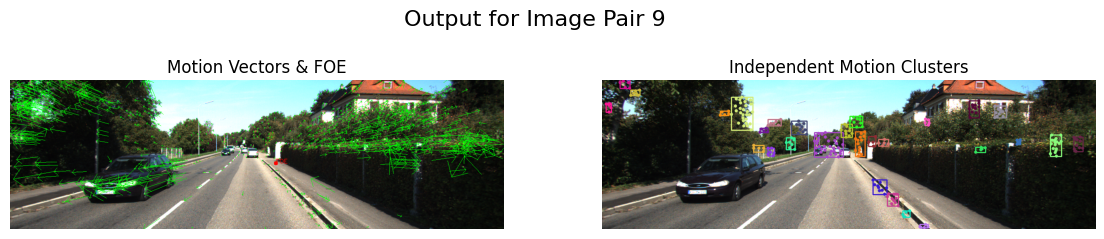

Processing pair: hw6data/000105_10.png and hw6data/000105_11.png
Estimated FOE: [761.8631  130.87187]
Total tracked points: 972, Independent points: 531


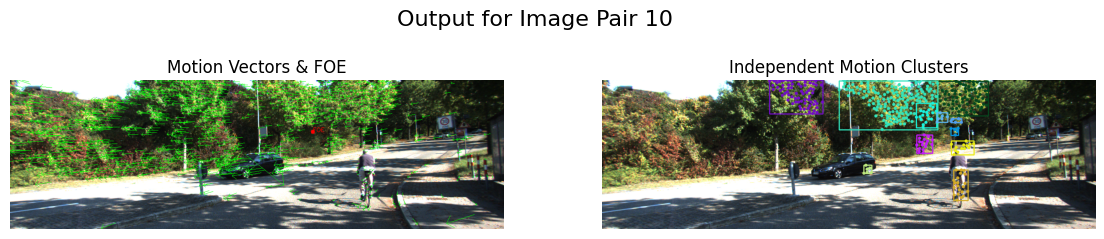

Processing pair: hw6data/000109_10.png and hw6data/000109_11.png
Estimated FOE: [484.0002  119.81525]
Total tracked points: 997, Independent points: 730


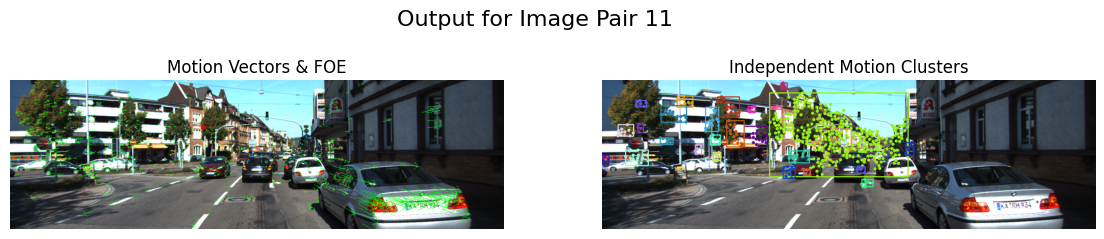

Processing pair: hw6data/000110_10.png and hw6data/000110_11.png
Estimated FOE: [528.8201  196.32515]
Total tracked points: 991, Independent points: 821


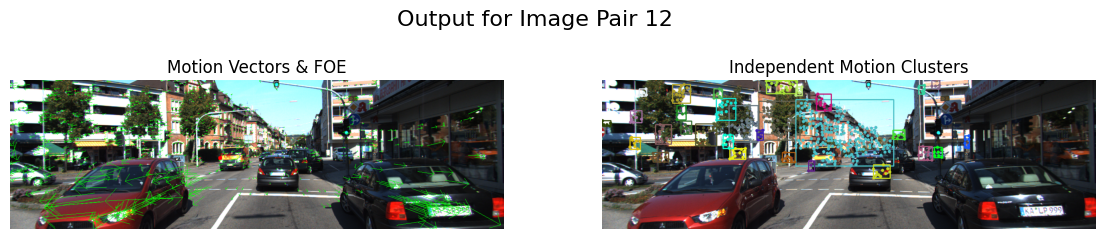

Processing pair: hw6data/000123_10.png and hw6data/000123_11.png
Estimated FOE: [594.8325  196.79143]
Total tracked points: 967, Independent points: 311


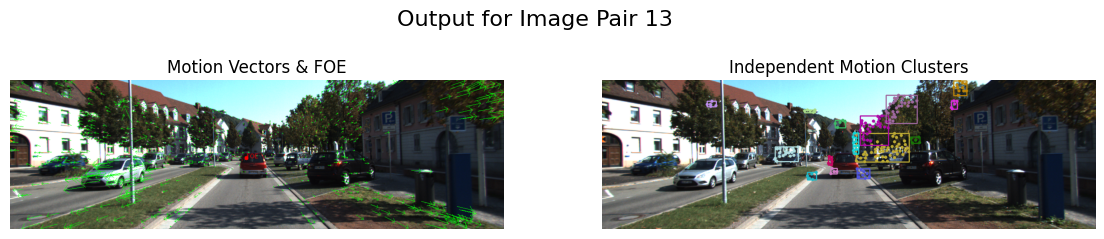

Processing pair: hw6data/000130_10.png and hw6data/000130_11.png
Estimated FOE: [133.81424 230.26529]
Total tracked points: 1000, Independent points: 972


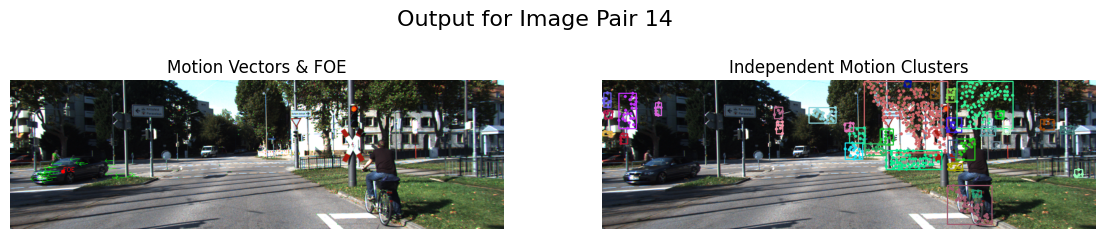

Processing pair: hw6data/000131_10.png and hw6data/000131_11.png
Estimated FOE: [228.21635 194.7066 ]
Total tracked points: 986, Independent points: 927


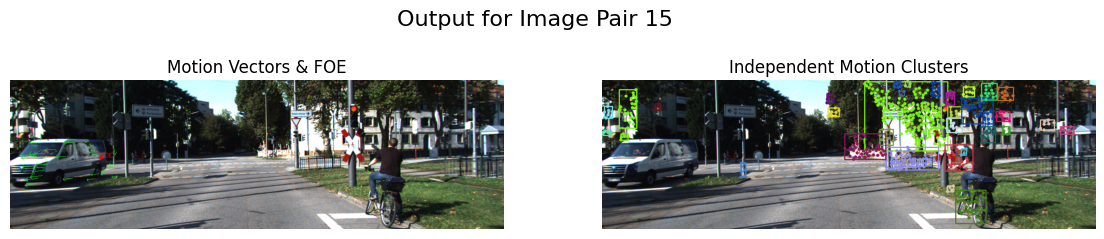

Processing pair: hw6data/000149_10.png and hw6data/000149_11.png
Estimated FOE: [1050.9264   223.89091]
Total tracked points: 852, Independent points: 758


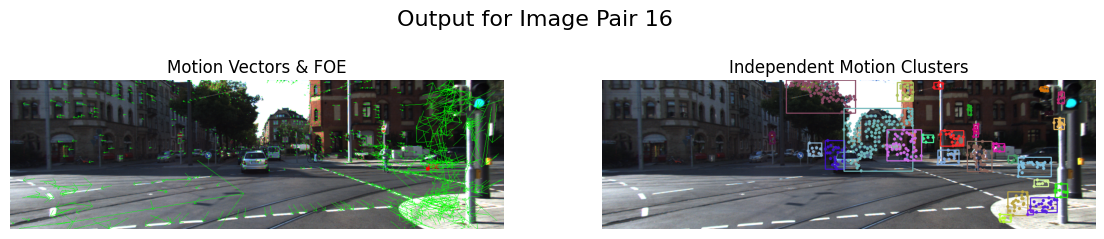

Processing pair: hw6data/000150_10.png and hw6data/000150_11.png
Estimated FOE: [641.12103 146.03444]
Total tracked points: 979, Independent points: 466


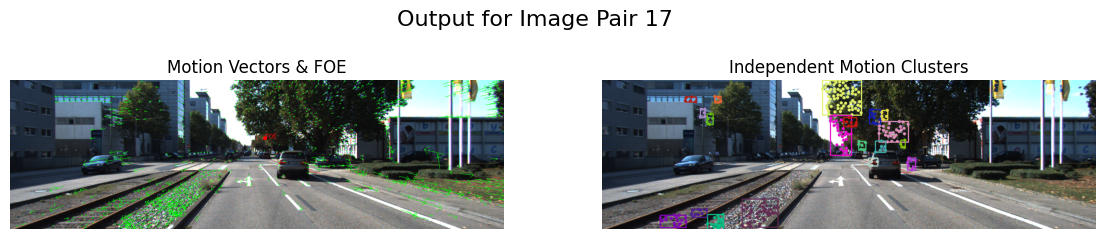

Processing pair: hw6data/000151_10.png and hw6data/000151_11.png
Estimated FOE: [898.3513  141.96785]
Total tracked points: 984, Independent points: 797


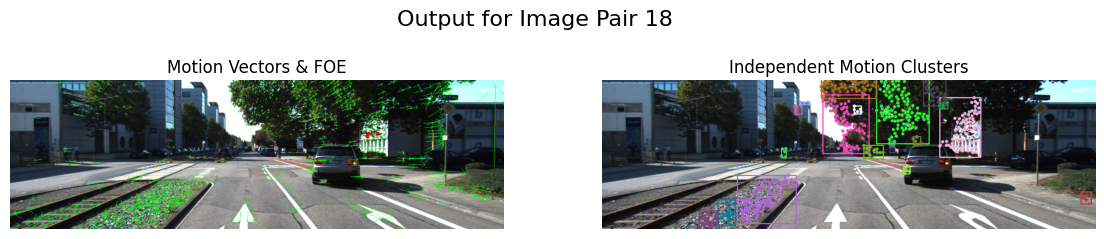

Processing pair: hw6data/000169_10.png and hw6data/000169_10_0.png
Estimated FOE: [624.9195  248.20558]
Total tracked points: 1000, Independent points: 814


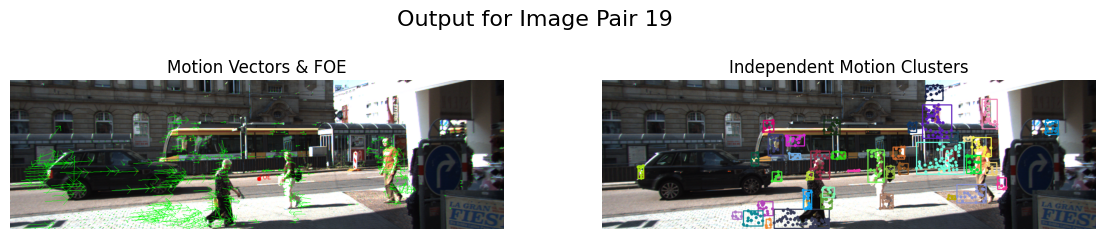

Processing pair: hw6data/000169_10_1.png and hw6data/000169_10_2.png
Estimated FOE: [789.95685  99.30283]
Total tracked points: 979, Independent points: 625


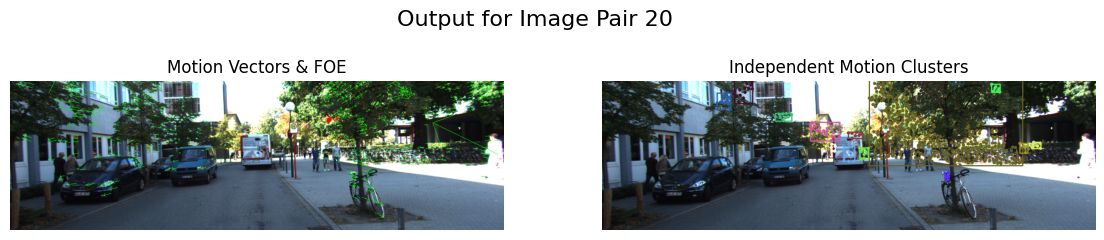

Processing pair: hw6data/000170_10.png and hw6data/000170_11.png
Estimated FOE: [592.4671  190.35344]
Total tracked points: 971, Independent points: 193


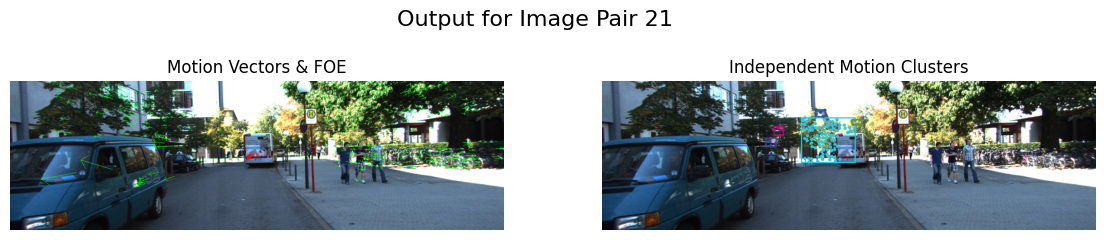

Processing pair: hw6data/000182_10.png and hw6data/000182_11.png
Estimated FOE: [836.74963  80.92433]
Total tracked points: 935, Independent points: 645


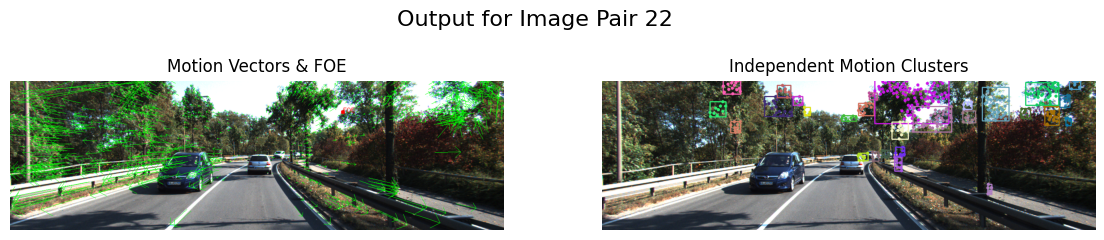

Processing pair: hw6data/000186_10.png and hw6data/000186_11.png
Estimated FOE: [557.7763  153.44583]
Total tracked points: 949, Independent points: 440


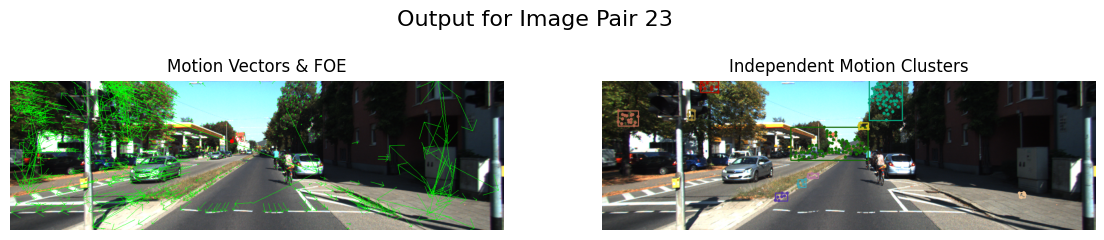

Processing pair: hw6data/000198_10.png and hw6data/000198_11.png
Estimated FOE: [604.28815 206.42123]
Total tracked points: 936, Independent points: 203


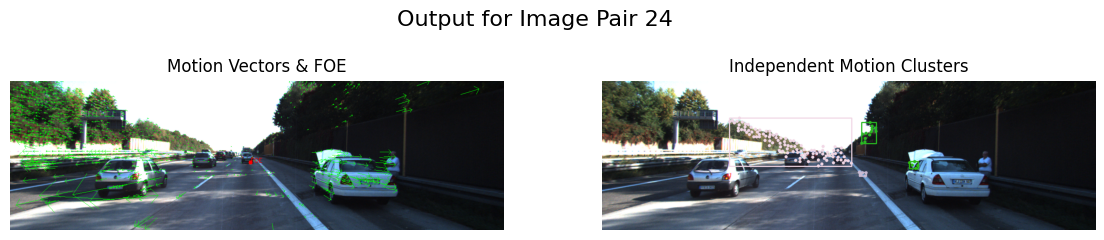

Processing pair: hw6data/000199_10.png and hw6data/000199_11.png
Estimated FOE: [537.56915 285.0398 ]
Total tracked points: 924, Independent points: 821


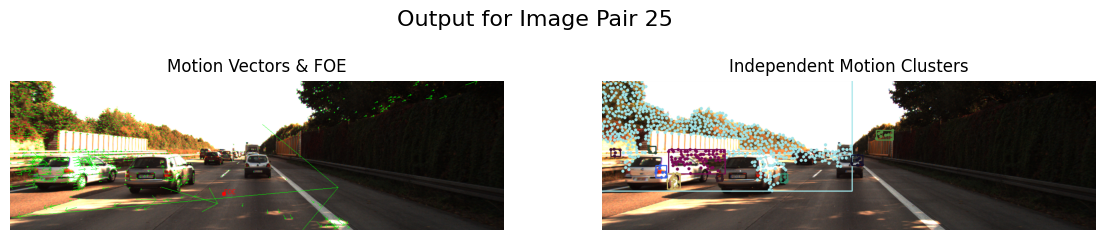

In [ ]:
def main():
    data_dir = "hw6data"
    pairs = get_image_pairs(data_dir)
    if not pairs:
        print("No image pairs found in the data directory.")
        return
    
    for idx, (img_path0, img_path1) in enumerate(pairs, start=1):
        vis_img, cluster_img = process_image_pair(img_path0, img_path1, pair_index=idx)
        if vis_img is not None and cluster_img is not None:
            #BGR to RGB for pyplot
            vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
            cluster_img_rgb = cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB)
            
            #create a figure with two subplots.
            fig, axs = plt.subplots(1, 2, figsize=(14, 3))
            fig.suptitle(f"Output for Image Pair {idx}", fontsize=16)
            
            axs[0].imshow(vis_img_rgb)
            axs[0].axis('off')
            axs[0].set_title("Motion Vectors & FOE")
            
            axs[1].imshow(cluster_img_rgb)
            axs[1].axis('off')
            axs[1].set_title("Independent Motion Clusters")
            
            plt.show()

if __name__ == '__main__':
    main()